In [47]:
# import necessay modules
import numpy as np
import torch
import torchinfo
import torch.nn.functional as F  # Parameterless functions, like (some) activation functions
import torchvision.datasets as datasets  # Standard datasets
from torch.utils.data import Dataset, DataLoader # Gives easier dataset managment by creating mini batches etc.
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms  # Transformations we can perform on our dataset for augmentation
from torch import optim  # For optimizers like SGD, Adam, etc.
from torch import nn  # All neural network modules
from tqdm import tqdm # for nice 
import matplotlib.pyplot as plt

In [48]:
# device config
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu') # 

#### Hyper Parameter

In [49]:
NUM_WORKERS = 4
BATCH_SIZE = 20
PIN_MEMORY = True
LOAD_MODEL = True
SAVE_MODEL = True
CHECKPOINT_FILE = "b7.pth.tar"
WEIGHT_DECAY = 1e-4
LEARNING_RATE = 0.001
NUM_EPOCHS = 3
VALID_SIZE= .2

In [50]:
def get_dataloader(batch_size):

    # percentage of training set to use as validation
    valid_size = 0.2

    # convert data to torch.FloatTensor
    transform = transforms.ToTensor()

    # choose the training and test datasets
    train_data = datasets.MNIST(root='./data', 
                                train=True,
                                download=True, 
                                transform=transform)

    test_data = datasets.MNIST(root='./data',
                               train=False,
                               download=True,
                               transform=transform)

    # obtain training indices that will be used for validation
    num_train = len(train_data)
    indices = list(range(num_train))
    np.random.shuffle(indices)
    split = int(np.floor(valid_size * num_train))
    train_idx, valid_idx = indices[split:], indices[:split]
    
    # define samplers for obtaining training and validation batches
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)
    
    # load training data in batches
    train_loader = torch.utils.data.DataLoader(train_data,
                                               batch_size=batch_size,
                                               sampler=train_sampler,
                                               num_workers=0)
    
    # load validation data in batches
    valid_loader = torch.utils.data.DataLoader(train_data,
                                               batch_size=batch_size,
                                               sampler=valid_sampler,
                                               num_workers=0)
    
    # load test data in batches
    test_loader = torch.utils.data.DataLoader(test_data,
                                              batch_size=batch_size,
                                              num_workers=0)
    
    return train_loader, test_loader, valid_loader

In [51]:
## Visualize data
def visualize_data(data_loader):
    dataiter = iter(data_loader)
    images, labels = next(dataiter)
    images = images.numpy()

    fig = plt.figure(figsize=(25, 4))
    for idx in np.arange(20):
        ax = fig.add_subplot(2, 10, idx + 1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(images[idx]), cmap='gray')
        # print out the correct label for each image
        ax.set_title(str(labels[idx].item()))

    plt.show()  

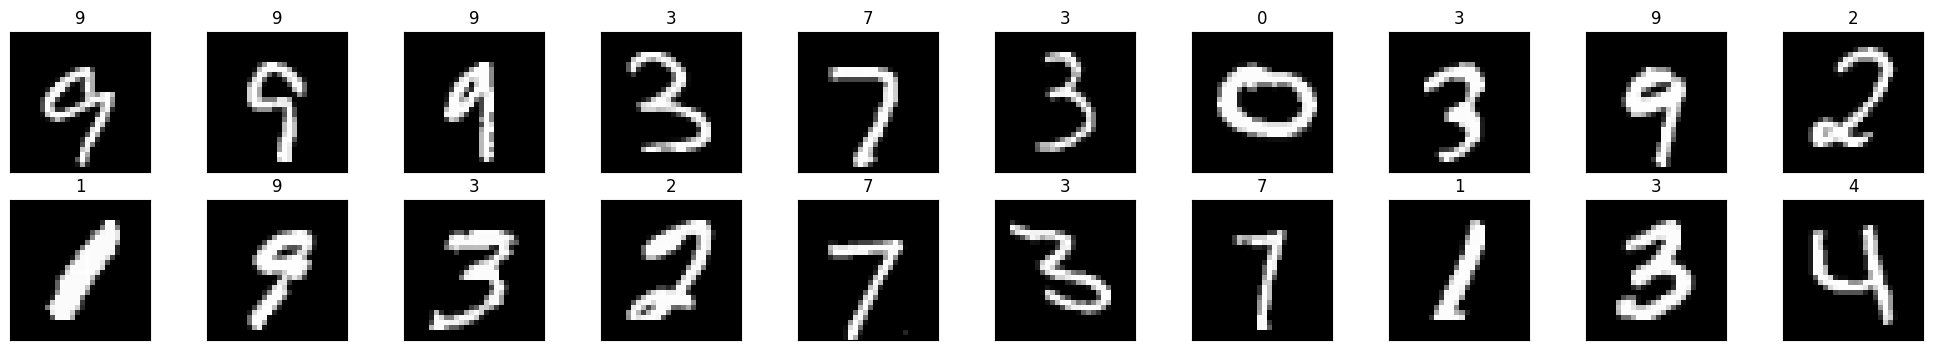

In [52]:
train_loader, test_loader, valid_loader = get_dataloader(batch_size=BATCH_SIZE)
visualize_data(train_loader)

In [53]:
def show_single_image(data_loader):
    dataiter = iter(data_loader)
    images, labels = next(dataiter)
    images = images.numpy()
    img = np.squeeze(images[1])

    fig = plt.figure(figsize = (12,12)) 
    ax = fig.add_subplot(111)
    ax.imshow(img, cmap='gray')
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                        horizontalalignment='center',
                        verticalalignment='center',
                        color='white' if img[x][y]<thresh else 'black')

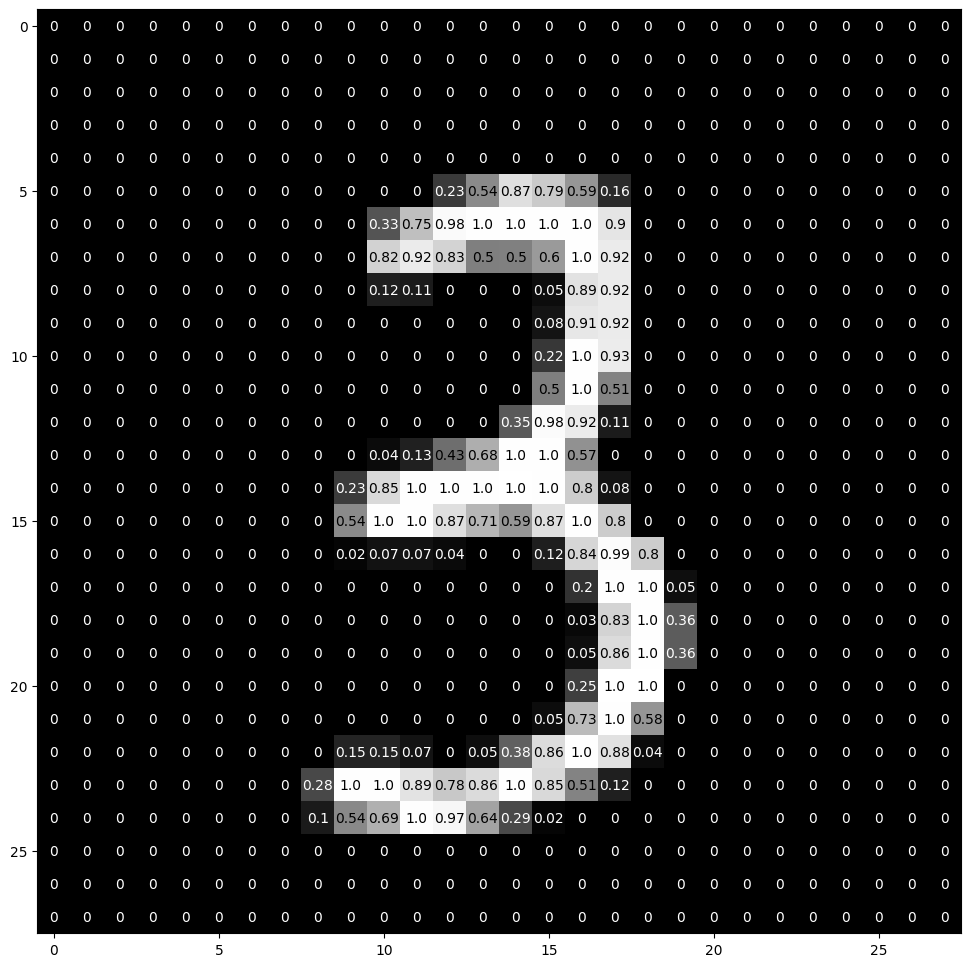

In [54]:
show_single_image(train_loader)

### Simple CNN architecture

In [55]:
class CNNNet(nn.Module):
    def __init__(self, in_channels =1, num_classes=10):
        super(CNNNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels= 8, kernel_size=(3,3),stride=(1,1), padding=(1,1))
        self.pool = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
        self.conv2 = nn.Conv2d(in_channels = 8, out_channels= 16, kernel_size=(3,3),stride=(1,1), padding=(1,1))
        self.fc1 = nn.Linear(16*7*7, num_classes)
    
    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc1(x)

        return x

In [56]:
def save_checkpoint(filename, model, optimizer, train_acc, epoch):
    save_state = {
        "state_dict": model.state_dict(),
        "acc": train_acc,
        "epoch": epoch + 1,
        "optimizer": optimizer.state_dict(),
    }
    print()
    print("Saving current parameters")
    print("___________________________________________________________")

    torch.save(save_state, filename)

In [57]:
def load_model(args, model, optimizer):
    if args.resume:
        model.eval()
        if os.path.isfile(args.resume):
            print("=> loading checkpoint '{}'".format(args.resume))
            checkpoint = torch.load(args.resume)
            start_epoch = checkpoint["epoch"]
            best_acc = checkpoint["acc"]
            model.load_state_dict(checkpoint["state_dict"])
            optimizer.load_state_dict(checkpoint["optimizer"])
            print(
                "=> loaded checkpoint '{}' (epoch {})".format(
                    args.resume, checkpoint["epoch"]
                )
            )
            return model, optimizer, checkpoint, start_epoch, best_acc
        else:
            print("=> no checkpoint found at '{}'".format(args.resume))
    else:
        print("No pretrained model. Starting from scratch!")

### Specify Loss Function and Optimizer

In [58]:
model= CNNNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

In [66]:
def train_network(model, batch_size,  n_epochs):
    
    # to track the training loss as the model trains
    train_losses = []
    # to track the validation loss as the model trains
    valid_losses = []
    # to track the average training loss per epoch as the model trains
    avg_train_losses = []
    # to track the average validation loss per epoch as the model trains
    avg_valid_losses = [] 
    
    valid_loss_min = np.Inf 
    # initialize the early_stopping object
    # early_stopping = EarlyStopping( verbose=True)
    
    for epoch in range(1, n_epochs + 1):

        model.train() # prep model for training
        for batch, (data, target) in enumerate(train_loader, 1):
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # record training loss
            train_losses.append(loss.item())

        ######################    
        # validate the model #
        ######################
        model.eval() # prep model for evaluation
        for data, target in valid_loader:
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            loss = criterion(output, target)
            # record validation loss
            valid_losses.append(loss.item())

        # print training/validation statistics 
        # calculate average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
        
        epoch_len = len(str(n_epochs))
        
        print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.5f} ' +
                     f'valid_loss: {valid_loss:.5f}')
        
        print(print_msg)
        
        # clear lists to track next epoch
        train_losses = []
        valid_losses = []
        
        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        # early_stopping(valid_loss, model)
        
        
        # save model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), 'model.pt')
            valid_loss_min = valid_loss
        
    # load the last checkpoint with the best model
    # model.load_state_dict(torch.load('checkpoint.pt'))

    return  model, avg_train_losses, avg_valid_losses

In [70]:
model, train_loss, valid_loss = train_network(model, BATCH_SIZE, 50)

[ 1/50] train_loss: 0.22812 valid_loss: 0.22133
Validation loss decreased (inf --> 0.221325).  Saving model ...
[ 2/50] train_loss: 0.21447 valid_loss: 0.20779
Validation loss decreased (0.221325 --> 0.207789).  Saving model ...
[ 3/50] train_loss: 0.20170 valid_loss: 0.19912
Validation loss decreased (0.207789 --> 0.199120).  Saving model ...
[ 4/50] train_loss: 0.19007 valid_loss: 0.18540
Validation loss decreased (0.199120 --> 0.185398).  Saving model ...
[ 5/50] train_loss: 0.17986 valid_loss: 0.18361
Validation loss decreased (0.185398 --> 0.183613).  Saving model ...
[ 6/50] train_loss: 0.17014 valid_loss: 0.17105
Validation loss decreased (0.183613 --> 0.171046).  Saving model ...
[ 7/50] train_loss: 0.16245 valid_loss: 0.16167
Validation loss decreased (0.171046 --> 0.161667).  Saving model ...
[ 8/50] train_loss: 0.15379 valid_loss: 0.16088
Validation loss decreased (0.161667 --> 0.160880).  Saving model ...
[ 9/50] train_loss: 0.14753 valid_loss: 0.14969
Validation loss decre

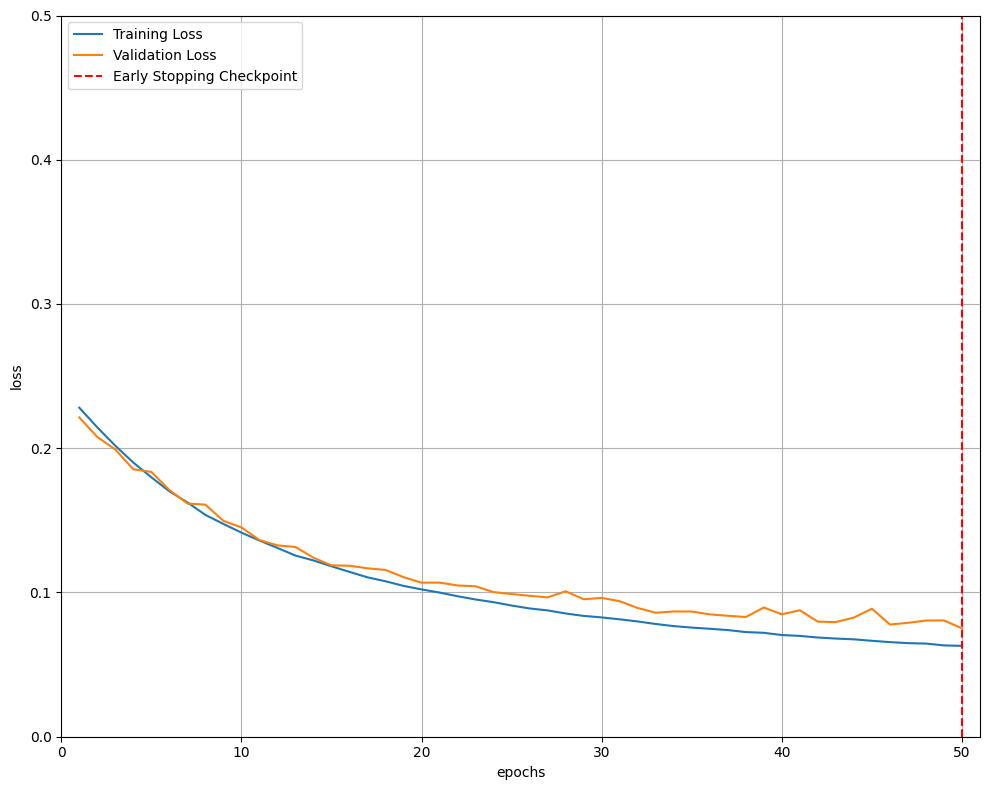

In [71]:

# visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')

# find position of lowest validation loss
minposs = valid_loss.index(min(valid_loss))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, 0.5) # consistent scale
plt.xlim(0, len(train_loss)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches='tight')

In [72]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, 1)
    correct = torch.sum(preds == labels).item()
    total = labels.size(0)
    return correct / total

In [73]:
def precision_recall_f1(outputs, labels, num_classes=10):
    TP = torch.zeros(num_classes)
    FP = torch.zeros(num_classes)
    FN = torch.zeros(num_classes)
    
    _, preds = torch.max(outputs, 1)
    
    for i in range(num_classes):
        TP[i] = torch.sum((preds == i) & (labels == i)).item()
        FP[i] = torch.sum((preds == i) & (labels != i)).item()
        FN[i] = torch.sum((preds != i) & (labels == i)).item()

    precision = TP / (TP + FP + 1e-10)
    recall = TP / (TP + FN + 1e-10)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-10)
    
    avg_precision = precision.mean().item()
    avg_recall = recall.mean().item()
    avg_f1 = f1.mean().item()
    
    return avg_precision, avg_recall, avg_f1

In [74]:
def confusion_matrix(outputs, labels, num_classes=10):
    _, preds = torch.max(outputs, 1)
    cm = torch.zeros(num_classes, num_classes)
    
    for t, p in zip(labels.view(-1), preds.view(-1)):
        cm[t.long(), p.long()] += 1
    
    return cm

In [78]:
def evaluate(model, device, test_loader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    all_outputs = []
    all_labels = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)

            # Accumulate predictions and labels
            all_outputs.append(outputs)
            all_labels.append(target)

            # Calculate accuracy for the current batch
            correct += (outputs.argmax(1) == target).sum().item()
            total += target.size(0)

    # Convert list of tensors to single tensor
    all_outputs = torch.cat(all_outputs)
    all_labels = torch.cat(all_labels)

    # Accuracy
    acc = correct / total
    print(f'Accuracy: {acc * 100:.2f}%')

    # Precision, Recall, F1-Score
    precision, recall, f1 = precision_recall_f1(all_outputs, all_labels, num_classes=10)
    print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}')
    
    # Confusion Matrix
    cm = confusion_matrix(all_outputs, all_labels, num_classes=10)
    print(f'Confusion Matrix:\n{cm}')

    return acc, precision, recall, f1, cm

# Evaluate the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
acc, precision, recall, f1, cm =evaluate(model, device, test_loader)


Accuracy: 98.17%
Precision: 0.9817, Recall: 0.9816, F1-Score: 0.9816
Confusion Matrix:
tensor([[9.7200e+02, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
         2.0000e+00, 2.0000e+00, 3.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.1290e+03, 4.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
         1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.0000e+00, 2.0000e+00, 1.0110e+03, 0.0000e+00, 2.0000e+00, 0.0000e+00,
         1.0000e+00, 9.0000e+00, 5.0000e+00, 1.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 9.9200e+02, 0.0000e+00, 5.0000e+00,
         0.0000e+00, 6.0000e+00, 4.0000e+00, 2.0000e+00],
        [1.0000e+00, 0.0000e+00, 2.0000e+00, 2.0000e+00, 9.6300e+02, 0.0000e+00,
         3.0000e+00, 1.0000e+00, 2.0000e+00, 8.0000e+00],
        [2.0000e+00, 1.0000e+00, 0.0000e+00, 2.0000e+00, 0.0000e+00, 8.7900e+02,
         2.0000e+00, 2.0000e+00, 4.0000e+00, 0.0000e+00],
        [5.0000e+00, 2.0000e+00, 0.0000e+00, 1.0000e+00, 2.0000e+00, 3.0000e+00

In [79]:
print(cm.size())

torch.Size([10, 10])


In [80]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

# Simulate confusion matrix creation
confusion_matrix = np.zeros((10, 10), dtype=int)
for t, p in zip(all_labels, all_preds):
    confusion_matrix[t, p] += 1

# Function to plot confusion matrix using Matplotlib
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized Confusion Matrix")
    else:
        print('Confusion Matrix, without Normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

# Define class names for MNIST (digits 0-9)
class_names = [str(i) for i in range(10)]

# Plot non-normalized confusion matrix
plt.figure(figsize=(8, 6))
plot_confusion_matrix(confusion_matrix, classes=class_names, title='Confusion Matrix')
plt.show()


NameError: name 'all_labels' is not defined